**<center><font size="6">Conteggi di Ammassi di Galassie per Euclid<font>**

<center><font size="5">a cura di Gabriele Furlani<font>

### Introduzione teorica
La missione **Euclid**, sviluppata dall'*Agenzia Spaziale Europea (ESA)*, ha come obiettivo lo studio della geometria dell'Universo oscuro. L'omonimo telescopio spaziale è stato lanciato il 1º luglio 2023 e si dedicherà alla misurazione della distribuzione e della forma di miliardi di galassie, offrendo agli scienziati nuovi strumenti per indagare la materia oscura e l’energia oscura, elementi chiave che regolano l’espansione cosmica.

Gli **ammassi di galassie**, che riuniscono centinaia se non addirittura migliaia di galassie, rappresentano le strutture più grandi dell’Universo, mantenute assieme dalla gravità. Le loro caratteristiche e la loro stessa esistenza forniscono indizi cruciali sia sulla formazione delle strutture cosmiche sia sulla natura della materia e dell'energia oscura. Grazie alla sua survey, Euclid riuscirà a identificare centinaia di migliaia di ammassi di galassie, seguendone l’evoluzione fin dalle prime fasi di formazione.

Il campo di ricerca noto come **cluster cosmology** sfrutta proprio gli ammassi di galassie per indagare le proprietà fondamentali dell’Universo. Poiché la loro distribuzione e il loro processo di formazione risultano estremamente sensibili ai parametri cosmologici, essi permettono di ottenere informazioni preziose sulla materia oscura, sull’energia oscura e sulle caratteristiche dell’Universo primordiale. In questo ambito, Trieste occupa una posizione di rilievo all’interno della collaborazione Euclid (e non solo), in particolare per gli studi di cosmologia basati sugli ammassi di galassie.
### Finalità della relazione
Lo scopo di questa relazione è analizzare un catalogo di ammassi di galassie, scelti con caratteristiche analoghe a quelle che saranno osservate dalla missione Euclid. L’analisi si concentra in particolare sullo studio della distribuzione delle masse di tali strutture, verificandone la conformità con le previsioni fornite dai modelli teorici attualmente disponibili. A partire da questo confronto, stimiamo i parametri cosmologici fondamentali, inferendoli dai dati e analizzandone le distribuzioni a posteriori. L’indagine viene svolta in diversi scenari, prendendo in considerazione sia un universo piatto sia un universo curvo, e valutando la dipendenza di tali parametri dal redshift.

In [197]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.stats as stats
import scipy.optimize as sopt
import emcee
import pygtc
from colossus.cosmology import cosmology
from colossus.lss import mass_function

## Parte 1 - Visualizzazione e Analisi dei Dati
Innanzitutto si scaricano i dati dal catalogo di ammassi di galassie fornito. Viene eliminata la prima colonna in quanto costituisce l'indice di ciasciuna riga.

In [200]:
data = pd.read_csv('Euclid_ammassi.csv')
data = data.drop(columns=data.columns[0])
data

,mass,z,vol
0,1.060613e+14,0.506,1.479387e+10
1,1.097076e+14,0.506,1.479387e+10
2,1.588869e+14,0.506,1.479387e+10
3,1.336345e+14,0.506,1.479387e+10
4,3.078288e+14,0.506,1.479387e+10
...,...,...,...
362632,1.002043e+14,1.500,9.112247e+10
362633,1.267961e+14,1.500,9.112247e+10
362634,1.273208e+14,1.500,9.112247e+10
362635,1.093178e+14,1.500,9.112247e+10


Individuati tre intervalli di redshift e del corrispondente volume dell'universo, per ciascuno si mostra:
- il numero di ammassi di galassie contenuti;
- il valor medio della massa degli ammassi;
- il massimo e minimo valore della massa.

In [202]:
data.groupby(['z','vol']).aggregate(['count', 'mean', 'max', 'min'])

mass                                          
                     count          mean           max           min
z     vol                                                           
0.506 1.479387e+10  168897  1.754502e+14  2.231156e+15  1.000004e+14
1.019 4.783826e+10  142007  1.520161e+14  1.536768e+15  1.000036e+14
1.500 9.112247e+10   51733  1.370772e+14  9.605430e+14  1.000017e+14

Di seguito verrà visualizzata la distribuzione in scala logaritmica di tutte le masse degli ammassi di galassie contenute nel catalogo.

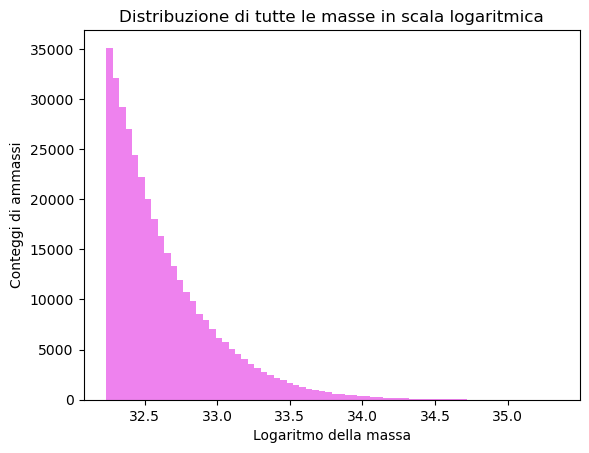

In [204]:
plt.hist(np.log(data['mass']),bins=70,color='violet')
plt.xlabel('Logaritmo della massa')
plt.ylabel('Conteggi di ammassi')
plt.title('Distribuzione di tutte le masse in scala logaritmica')
plt.show()

Si procede alla suddivisione delle masse in tre gruppi, uno per ciascun valore di redshift (z). Di ciascun gruppo verranno visualizzati i dati analogamente a prima.

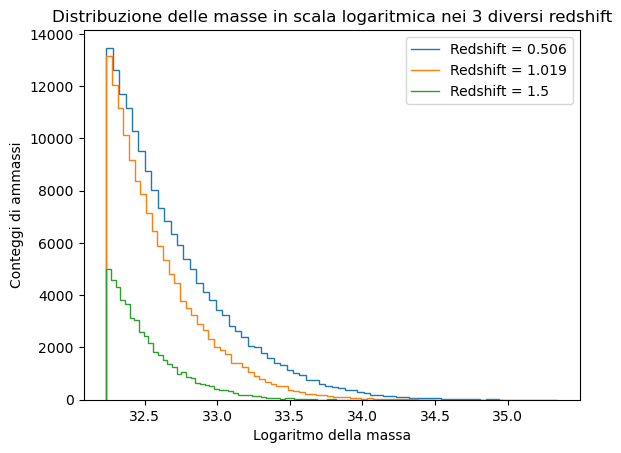

In [207]:
z_val=data['z'].unique() #ricavo i 3 valori del redshift
vol_val=data['vol'].unique() #ricavo i 3 valori del volume di universo
masse=[[],[],[]]
conteggi=[[],[],[]]
es_bin=[[],[],[]]
dm=[[],[],[]] #spessori dei bin in scala logaritmica

for i,z in enumerate(z_val):  
    masse[i]=data[data['z']==z]['mass'] #suddivisione in tre gruppi delle masse
    conteggi[i], es_bin[i]=np.histogram(np.log(masse[i]), bins=70)
    plt.stairs(conteggi[i], es_bin[i], label='Redshift = {}'.format(z))

    #ricavo la larghezza dei bin per ciascun z, serviranno successivamente
    dm[i]=es_bin[i][1]-es_bin[i][0]
    
plt.xlabel('Logaritmo della massa')
plt.ylabel('Conteggi di ammassi')
plt.title('Distribuzione delle masse in scala logaritmica nei 3 diversi redshift')
plt.legend()
plt.show()

### Osservazioni
- L'andamento di tutte e tre le distribuzioni è decrescente: in tutti i gruppi di redshift, la maggioranza di ammassi di galassie è costituita dagli ammassi con valori di massa minimi;
- Come era già possibile notare dalla preliminare analisi dei dati, ora è facilmente visibile la diminuzione del numero di ammassi di galassie all'aumentare del redshift ;
- Le distribuzioni delle masse suddivise in base ai tre valori del redshift posseggono un andamento simile: per ciò si ipotizza che possano essere descritte da una stessa funzione al fine di compiere predizioni teoriche.

## Parte 2 - Analisi della Halo Mass Function (HMF)
Si intende ora verificare se la distribuzione ottenuta dal campione di ammassi di galassie sia coerente con l’andamento previsto dal modello teorico. I valori teorici vengono calcolati attraverso una funzione specifica, la _Halo Mass Function_ (HMF), la quale fornisce la distribuzione attesa a partire da un set di parametri cosmologici assegnati e in funzione del redshift. L’analisi viene condotta separatamente per ciascun valore di redshift, in modo da confrontare sistematicamente i dati empirici con le previsioni teoriche nell’ipotesi di un universo piatto.

In [210]:
def mfunc(theta,z,es_bin,dm,vol): #HMF
    Om0, s8 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': s8, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    #ricavo i centri dei bin degli istogrammi precedenti senza scala logaritmica
    m_arr=np.exp(es_bin)
    m_arr=(m_arr[:-1] + m_arr[1:])/2

    #calcolo i valori attesi con la funzione data
    mfunc=mass_function.massFunction(m_arr, z, mdef='vir', model='despali16', q_out='dndlnM')
    val_att=mfunc*vol*dm
    
    return m_arr,val_att

Di seguito si visualizzano i tre andamenti teorici calcolati con la funzione sopra descritta (mfunc).

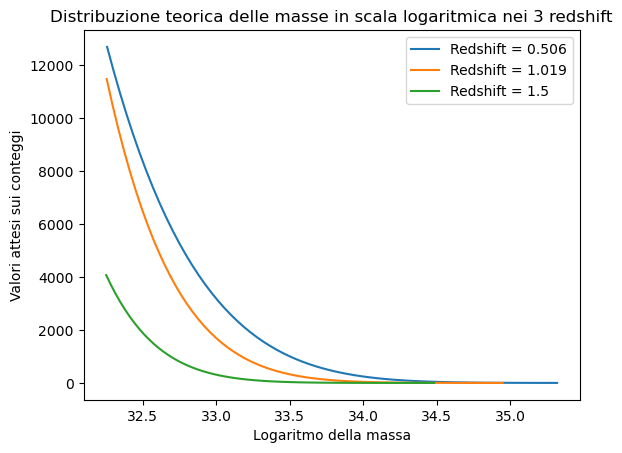

In [213]:
for i,z in enumerate(z_val):
        
    #calcolo i valori attesi con la funzione data
    m_arr,val_att=mfunc([0.31,0.81],z,es_bin[i],dm[i],vol_val[i])
    plt.plot(np.log(m_arr), val_att, label='Redshift = {}'.format(z))

plt.xlabel('Logaritmo della massa')   
plt.ylabel('Valori attesi sui conteggi')   
plt.title('Distribuzione teorica delle masse in scala logaritmica nei 3 redshift')
plt.legend()
plt.show()

Prima di verificare se tali valori attesi rappresentino una buona previsione dei conteggi osservati, si vuole studiare il comportamento della HMF al variare dei parametri $\Omega_m$ e $\sigma_8$, sempre mantenendo la suddivisione per redshift differenti.

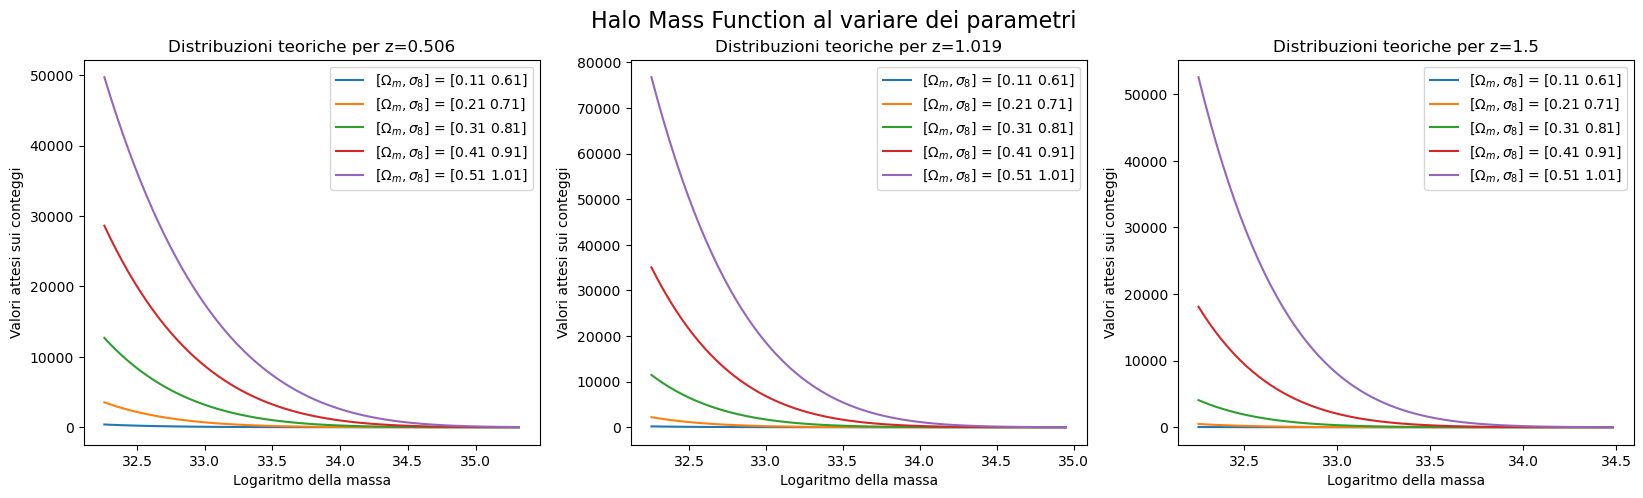

In [215]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i,z in enumerate(z_val):
    for j in range(5):
        param=np.array([0.11,0.61])+0.1*j
        m_arr,val_att=mfunc(param,z,es_bin[i],dm[i],vol_val[i])
        axes[i].plot(np.log(m_arr), val_att, label='[$\\Omega_m,\\sigma_8$] = {}'.format(param))
    axes[i].set_xlabel('Logaritmo della massa')
    axes[i].set_ylabel('Valori attesi sui conteggi')
    axes[i].set_title(f'Distribuzioni teoriche per z={z}')
    axes[i].legend()

fig.suptitle('Halo Mass Function al variare dei parametri', fontsize=16)
plt.show()

Ora si mostra il confronto degli andamenti ottenuti dal campione con i valori teorici ricavati.

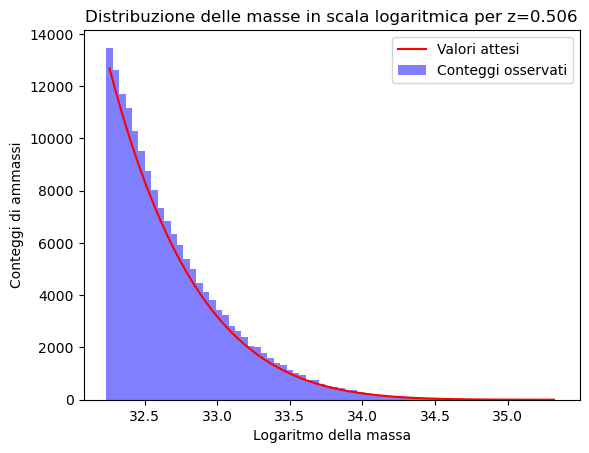

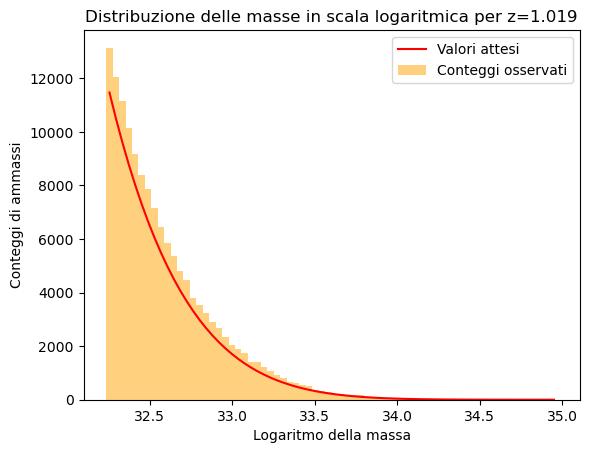

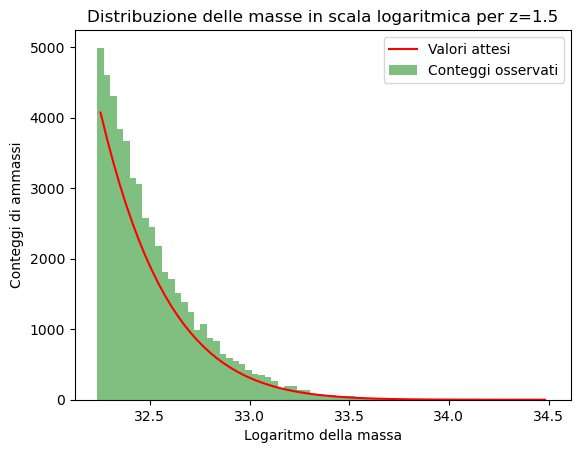

In [217]:
colori=['blue','orange','green']
chi_sq_flat=[0,0,0]
gdl_flat=[-1,-1,-1]
for i,z in enumerate(z_val):
    
    #ricalcolo i valori attesi
    m_arr,val_att=mfunc([0.31,0.81],z,es_bin[i],dm[i],vol_val[i])
    plt.plot(np.log(m_arr), val_att, c='red', label='Valori attesi')
    
    #ricreo gli istogrammi
    plt.hist(np.log(masse[i]),bins=70,color=colori[i],alpha=0.5,label='Conteggi osservati')
    
    plt.xlabel('Logaritmo della massa')   
    plt.ylabel('Conteggi di ammassi')   
    plt.title(f'Distribuzione delle masse in scala logaritmica per z={z}')
    plt.legend()
    plt.show()

    #calcolo chi^2 del test di Pearson (discusso alla fine della relazione)
    for j in range(len(conteggi[i])):
        if conteggi[i][j]>=5:
            chi_sq_flat[i]+=(conteggi[i][j]-val_att[j])**2/val_att[j]
            gdl_flat[i]+=1
chi_red_flat=np.array(chi_sq_flat)/np.array(gdl_flat)

Per evidenziare l'accordo tra modello teorico e osservazioni, viene presentato il grafico dei residui:

<center> $residui\ =\ conteggi\ osservati\ -\ valori\ attesi$

Il residuo quantifica la differenza del modello teorico dai valori osservati. Una previsione teorica perfetta avrebbe tutti i residui nulli.

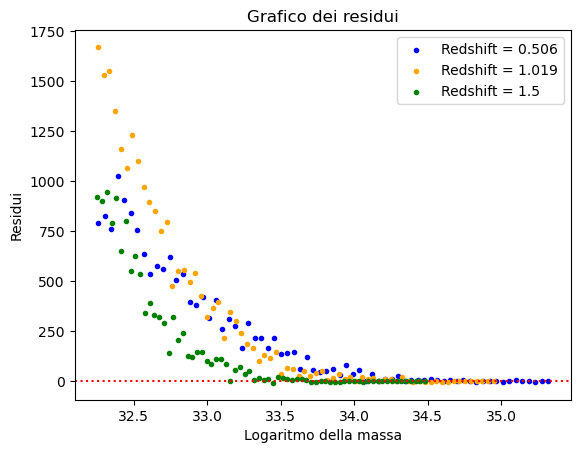

In [219]:
colori=['blue','orange','green']
for i,z in enumerate(z_val):
    
    #ricalcolo i valori attesi
    m_arr,val_att=mfunc([0.31,0.81],z,es_bin[i],dm[i],vol_val[i])
    
    res=conteggi[i]-val_att #calcolo dei residui
    plt.scatter(np.log(m_arr),res,color=colori[i],marker='.',label='Redshift = {}'.format(z))

plt.axhline(y=0, xmin=0, xmax=35.5,c='red',ls=':')
plt.xlabel('Logaritmo della massa')   
plt.ylabel('Residui')   
plt.title('Grafico dei residui')
plt.legend()
plt.show()

### Osservazioni
Dall’analisi emerge che la funzione descrive in maniera complessivamente soddisfacente l’andamento dei tre istogrammi: la distribuzione teorica fornita, sulla base dei parametri cosmologici fissati, rappresenta una buona approssimazione della distribuzione osservata delle masse degli ammassi. Tuttavia, pur in presenza di un evidente accordo tra i due andamenti, si rilevano delle differenze tra istogrammi e curve teoriche: in tutti e tre i casi osservati il modello teorico sottostima i conteggi osservati. Come mostrato nel grafico dei residui, il disaccordo risulta variabile a seconda del valore della massa e del redshift, suggerendo che i parametri cosmologici non possano essere considerati costanti.

## Parte 3 - Inferenza Bayesiana sui parametri cosmologici
### Modelli flat $\Lambda$-CDM
Dopo il confronto preliminare tra i dati empirici e le predizioni teoriche, si procede con un’analisi di inferenza bayesiana finalizzata all’ottimizzazione dei parametri cosmologici $\Omega_m$ e $\sigma_8$. Essi descrivono rispettivamente l’ampiezza delle fluttuazioni di densità della materia su scale di $8\ Mpc/h$ e la densità di materia totale, mentre gli altri parametri cosmologici vengono mantenuti fissati ai valori inizialmente assegnati.

Come ipotesi di partenza, si adottano prior uniformi per $\Omega_m$ e $\sigma_8$ nell’intervallo $[0.1,\,1.1]$. Inoltre, si assume che il numero di ammassi osservato in un determinato intervallo di massa ($n_{oss}$) sia una realizzazione poissoniana del numero teorico ($n_{teo}$) predetto dalla _Halo Mass Function_ (HMF). La funzione di likelihood è quindi costruita come prodotto delle distribuzioni di Poisson associate a ciascun intervallo, mentre il suo logaritmo naturale può essere espresso come segue:

$$
\ln \mathcal{L}(\Omega_m,\sigma_8\ |\ \mu,n) = \sum_i \ln \left( \frac{\mu_i^{n_i}}{n_i!}e^{-\mu_i}\right)
$$
dove $\mu_i=n_{teo}$ dell'i-esimo intervallo e $n_i=n_{oss}$ dell'i-esimo intervallo.

Per l’esplorazione dello spazio dei parametri, si utilizzerà l'algoritmo _EMCEE_, un campionatore _Markov Chain Monte Carlo_ (MCMC) basato su un approccio di _ensemble sampling_. L’analisi verrà condotta nel caso specifico di un universo piatto, con l’obiettivo di ottenere una stima ottimale di $\Omega_m$ e $\sigma_8$ a partire dai dati empirici.

Definisco le funzioni del prior, del likelihood e del posterior.

In [223]:
def log_prior(theta):
    Om0, s8 = theta
    if 0.1<=Om0<=1.1 and 0.1<=s8<=1.1: #distribuzione uniforme dei parametri
        return 0.0
    return -np.inf

def log_likelihood(theta,z,es_bin,dm,vol,n): #calcolato come nella formula sopra citata
    m_arr,val_att=mfunc(theta,z,es_bin,dm,vol)
    return np.nansum(stats.poisson.logpmf(n, val_att))

def log_posterior(theta,z,es_bin,dm,vol,n):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,z,es_bin,dm,vol,n)

Si avvia l'algoritmo EMCEE per ciascun valore di redshift usando come valori iniziali dei parametri quelli utilizzati nella prima parte ($\Omega_m=0.31$, $\sigma_8=0.81$). Successivamente si estraggono i campioni ottenuti.

100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]


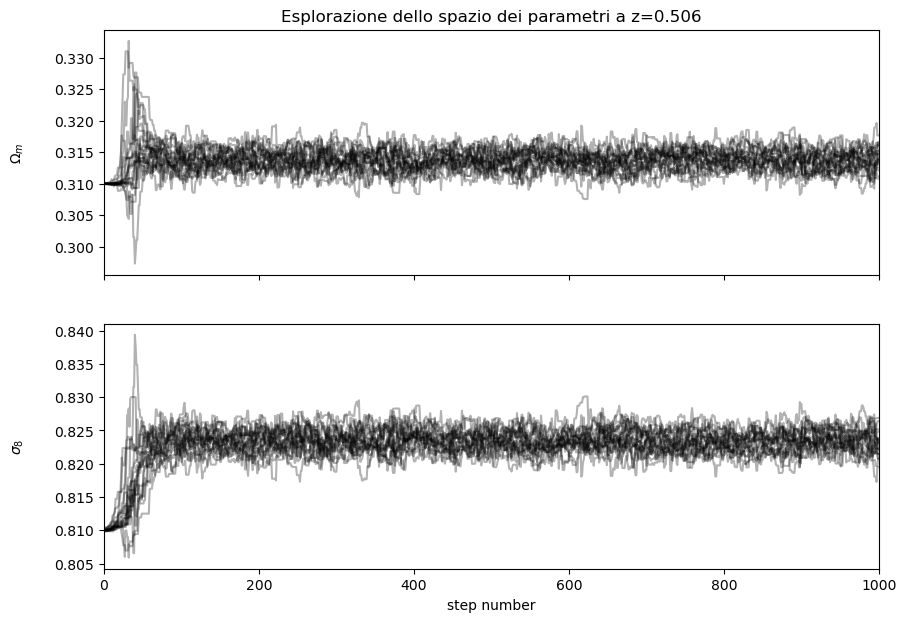

100%|██████████| 1000/1000 [04:46<00:00,  3.50it/s]


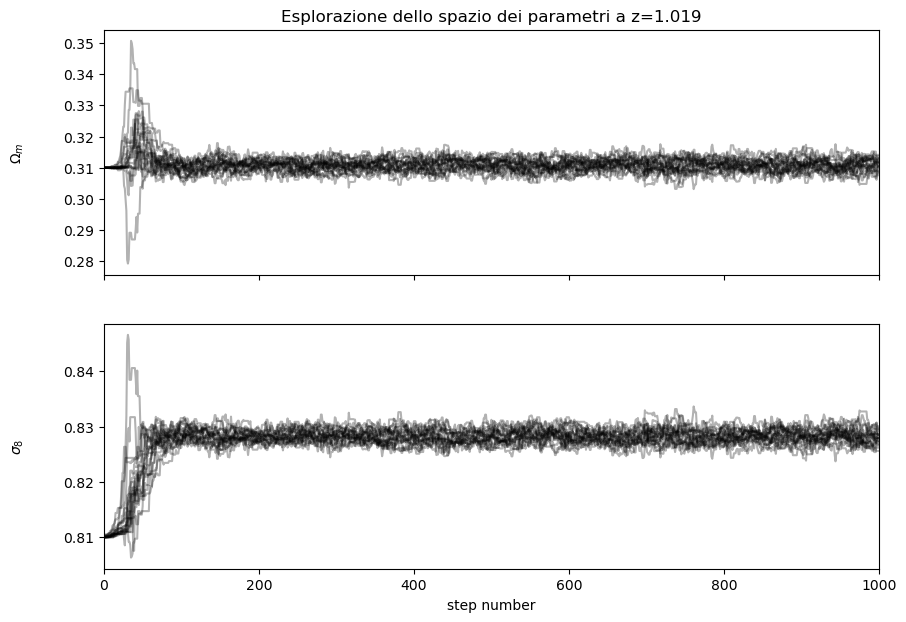

100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


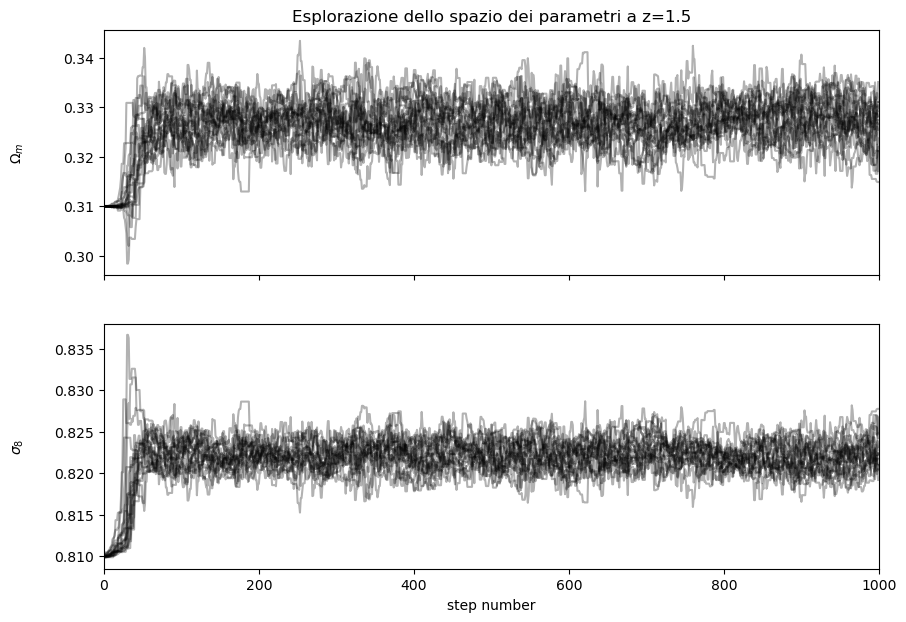

In [227]:
campione=[]
for i,z in enumerate(z_val):

    #avvio dell'algoritmo EMCEE: 20 walkers e 1000 steps
    np.random.seed(42)
    pos = np.array([0.31, 0.81]) *(1+ 1e-4 * np.random.randn(20, 2))
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z,es_bin[i],dm[i],vol_val[i],conteggi[i]))
    sampler.run_mcmc(pos, 1000, progress=True)

    #rappresento graficamente l'esplorazione dello spazio dei parametri
    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["$\\Omega_m$", "$\\sigma_8$"]
    for j in range(ndim):
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    axes[0].set_title(f"Esplorazione dello spazio dei parametri a z={z}")
    plt.show()

    #estraggo il campione
    flat_samples = sampler.get_chain(discard=150, flat=True)
    campione.append(flat_samples)

### Osservazioni
Dall’analisi dei grafici rappresentanti l'esplorazione dello spazio dei parametri, si osserva che, in seguito ad un periodo di _burn-in_ di circa 150 steps, le catene MCMC si sviluppano attorno a valori ben definiti senza mostrare segni di divergenza. Ciascuna catena tende infatti a stabilizzarsi attorno al valore d'aspettazione della distribuzione, che corrisponde al parametro più probabile secondo la distribuzione del posterior.

In accordo con la legge dei grandi numeri, la media dei campioni estratti tende al valore d'aspettazione della distribuzione al crescere del numero di iterazioni. Supponendo quindi che le catene abbiano raggiunto una lunghezza sufficiente e che i singoli valori dei parametri siano tra loro indipendenti, le migliori stime dei parametri cosmologici $\Omega_m$ e $\sigma_8$ possono essere ottenute come media complessiva dei valori campionati. Ciascuna stima può essere accompagnata dalla rispettiva deviazione standard, la quale quantifica l’incertezza statistica sul valore del parametro.

In [236]:
camp=np.array(campione)
stime=pd.DataFrame()
for i,z in enumerate(z_val):
    dict={'$\\Omega_m$':camp[i,:,0], '$\\sigma_8$':camp[i,:,1]} #seleziono le singole colonne per ogni z
    df=pd.DataFrame(dict,index=np.arange(i*len(camp[i,:,0]),(i+1)*len(camp[i,:,0]),1))
    df['z']=z
    stime=pd.concat([stime,df],axis=0)    
stime.groupby('z').aggregate(['mean','std'])

$\Omega_m$           $\sigma_8$          
            mean       std       mean       std
z                                              
0.506   0.313744  0.001638   0.823430  0.001666
1.019   0.310789  0.002026   0.828231  0.001286
1.500   0.327076  0.004053   0.822184  0.001759

Si verifica la **compatibilità** delle stime ottenute con i valori dei **parametri iniziali** entro tre deviazioni standard.

In [239]:
cond=(np.mean(camp,axis=1)-3*np.std(camp,axis=1))<=np.array([[0.31,0.81],[0.31,0.81],[0.31,0.81]])
comp=np.where(cond,'Si', 'No')
df=pd.DataFrame({'$\\Omega_m$':comp[:,0], '$\\sigma_8$':comp[:,1]},index=z_val)
df

,$\Omega_m$,$\sigma_8$
0.506,Si,No
1.019,Si,No
1.500,No,No


Solo due valori dei parametri stimati sono compatibili con i valori iniziali ($\Omega_m=0.31$, $\sigma_8=0.81$).

Si verifica la **reciproca compatibilità** delle stime ottenute entro tre deviazioni standard.

In [242]:
comp=[]
for i,z in enumerate(z_val):
    cond= np.abs(np.mean(camp,axis=1)[i-1,:]-np.mean(camp,axis=1)[i,:]) <= 3*np.sqrt(np.var(camp,axis=1)[i-1,:]+np.var(camp,axis=1)[i,:])
    comp.append(np.where(cond,'Si', 'No'))
comp=np.array(comp)
df=pd.DataFrame({'$\\Omega_m$':comp[:,0], '$\\sigma_8$':comp[:,1]},index=['0.506 vs 1.500', '0.506 vs 1.019', '1.019 vs 1.500'])
df

,$\Omega_m$,$\sigma_8$
0.506 vs 1.500,No,Si
0.506 vs 1.019,Si,Si
1.019 vs 1.500,No,Si


Solo due coppie di parametri stimati non sono compatibili tra loro.

Di seguito si rappresenta graficamente la distribuzione dei due parametri stimati per ciascun valore di redshift. In particolare si rappresenta la distribuzione del posterior ricavata dall'algoritmo EMCEE e proiettata sullo spazio dei parametri. Per ogni parametro si ottengono anche le distribuzioni marginali.

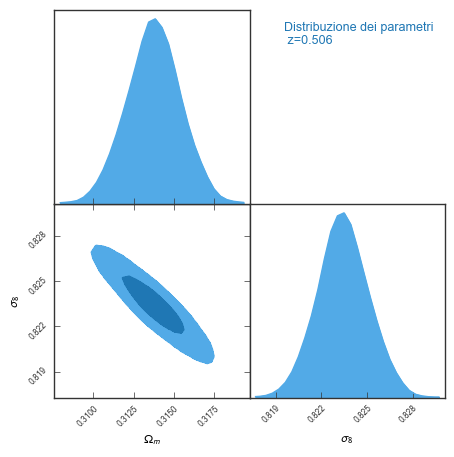

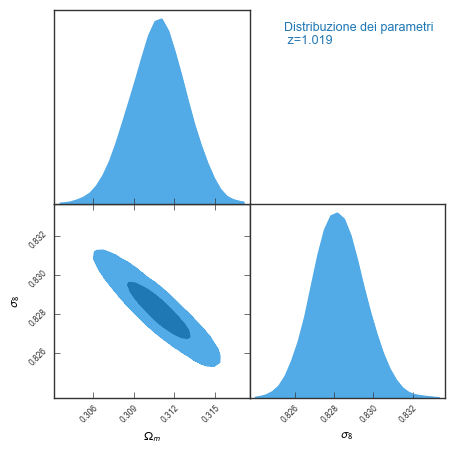

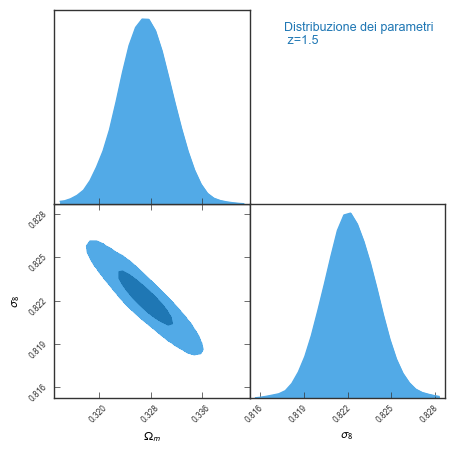

In [245]:
for i,z in enumerate(z_val):
    GTC = pygtc.plotGTC(chains=campione[i],
                        paramNames=["$\\Omega_m$", "$\\sigma_8$"],
                        chainLabels=[f'Distribuzione dei parametri\n z={z}'],
                        figureSize='MNRAS_page')

Si intende calcolare il coefficiente di correlazione tra $\Omega_m$ e $\sigma_8$ per ogni valore di redshift.

In [248]:
corr_coef=[]
for i,z in enumerate(z_val):
    corr_matrix=np.corrcoef(camp[i,:,:].T) #estraggo la matrice dei coefficienti di correlazione dal campione
    corr_coef.append(corr_matrix[0,1])
corr_coef=np.array(corr_coef)
df=pd.DataFrame({'$\\rho(\\Omega_m,\\sigma_8)$':corr_coef},index=z_val)
df

,"$\rho(\Omega_m,\sigma_8)$"
0.506,-0.964039
1.019,-0.970510
1.500,-0.979963


### Osservazioni
Dai grafici sopra riportati si osserva che le distribuzioni marginali risultano pressoché simmetriche intorno al proprio valore d'aspettazione, confermando la casualità del campionamento dell'algoritmo EMCEE. Inoltre la proiezione della distribuzione multivariata sullo spazio dei parametri assume la forma di un’ellisse inclinata con pendenza negativa, evidenziando una correlazione tra i parametri. La correlazione negativa, i cui valori sono esposti sopra, indica che i parametri tendono a compensarsi a vicenda: al crescere di uno, l'altro diminuisce.

A partire da questi valori ottimizzati, è possibile calcolare una nuova previsione teorica dei conteggi mediante la _Halo Mass Function_ (HMF) e confrontarla nuovamente con i dati osservati. L’obiettivo è verificare se l’impiego dei nuovi parametri stimati consenta di ottenere un migliore accordo tra modello teorico e osservazioni, riducendo così la differenza riscontrata nelle analisi precedenti. Si mostra tale confronto.

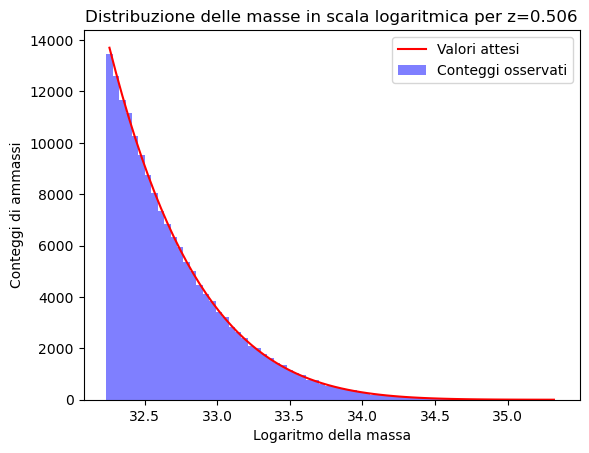

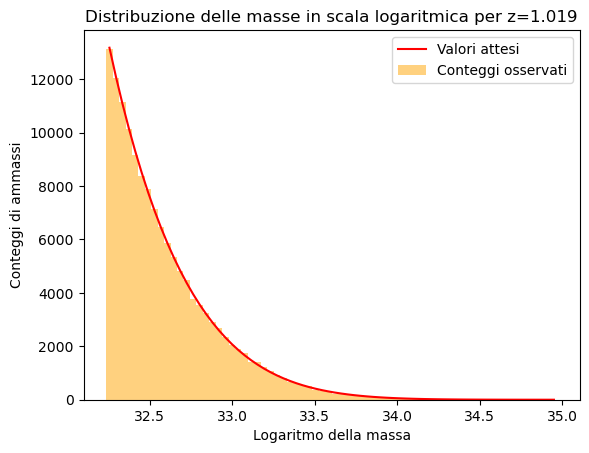

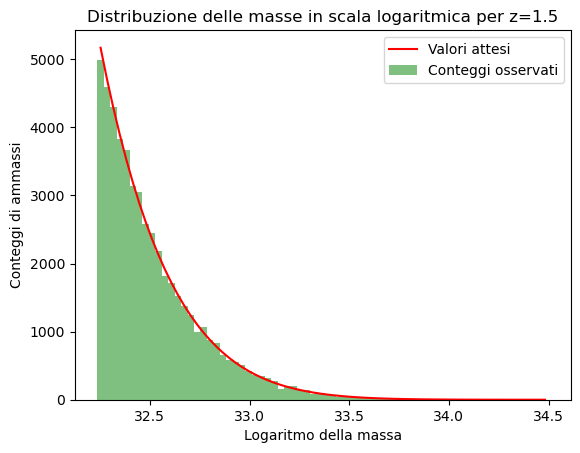

In [251]:
colori=['blue','orange','green']
chi_sq_flatp=[0,0,0]
gdl_flatp=[-3,-3,-3]
for i,z in enumerate(z_val):
    
    #calcolo i valori attesi con i parametri ottimizzati
    m_arr,val_att=mfunc(np.mean(camp,axis=1)[i,:],z,es_bin[i],dm[i],vol_val[i])
    plt.plot(np.log(m_arr), val_att, c='red', label='Valori attesi')
    
    #ricreo gli istogrammi
    plt.hist(np.log(masse[i]),bins=70,color=colori[i],alpha=0.5,label='Conteggi osservati')
    
    plt.xlabel('Logaritmo della massa')   
    plt.ylabel('Conteggi di ammassi')   
    plt.title(f'Distribuzione delle masse in scala logaritmica per z={z}')
    plt.legend()
    plt.show()

    #calcolo chi^2 del test di Pearson (discusso alla fine della relazione)
    for j in range(len(conteggi[i])):
        if conteggi[i][j]>=5:
            chi_sq_flatp[i]+=(conteggi[i][j]-val_att[j])**2/val_att[j]
            gdl_flatp[i]+=1
chi_red_flatp=np.array(chi_sq_flatp)/np.array(gdl_flatp)

Viene ripresentato il grafico dei residui con i nuovi valori attesi.

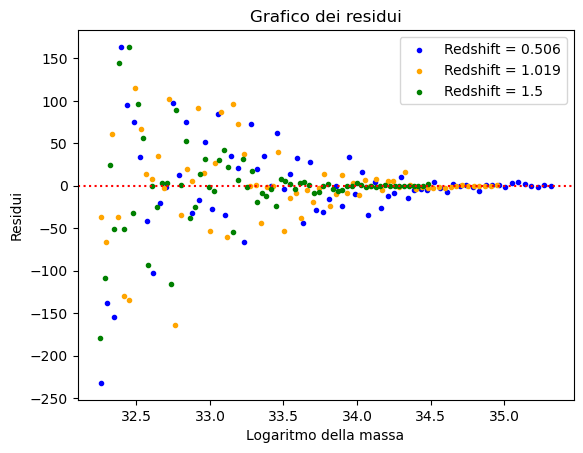

In [254]:
colori=['blue','orange','green']
for i,z in enumerate(z_val):
    
    #ricalcolo i valori attesi
    m_arr,val_att=mfunc(np.mean(camp,axis=1)[i,:],z,es_bin[i],dm[i],vol_val[i])
    
    res=conteggi[i]-val_att #calcolo dei residui
    plt.scatter(np.log(m_arr),res,color=colori[i],marker='.',label='Redshift = {}'.format(z))

plt.axhline(y=0, xmin=0, xmax=35.5,c='red',ls=':')
plt.xlabel('Logaritmo della massa')   
plt.ylabel('Residui')   
plt.title('Grafico dei residui')
plt.legend()
plt.show()

### Osservazioni
Dall’osservazione del confronto degli istogrammi con i nuovi valori attesi calcolati, emerge un migliore accordo tra modello teorico e dati empirici rispetto all'analisi precedente: i valori d'aspettazione di $\Omega_m$ e $\sigma_8$, ricavati dall'algoritmo EMCEE, si dimostrano dunque decisamente più accurati al fine di rappresentare la distribuzione degli ammassi di galassie osservati. Il nuovo grafico dei residui conferma tale associazione: si evidenzia ancora una maggiore dispersione dei residui negli intervalli relativi a masse minori, tuttavia ne si osserva pure una maggiore casualità; in precedenza si notava un'evidente sottostima dei conteggi. Anche il valore assoluto dei residui è globalmente minore rispetto a prima.
### Ha senso un'analisi congiunta?
L’inferenza bayesiana è stata condotta separatamente sui tre intervalli di redshift, così da stimare i parametri $\Omega_m$ e $\sigma_8$ in ciascun caso e confrontare la predizione teorica della HMF con i dati osservati. Senza la suddivisione in base agli intervalli di redshift, l’analisi globale avrebbe fornito una visione più ampia della distribuzione dei parametri cosmologici, riducendo l’incertezza statistica grazie al numero maggiore di campioni. Tuttavia, nella definizione della funzione per il calcolo dei valori attesi (mfunc), viene richiesta come variabile proprio il valore del redshift. Conducendo un'analisi congiunta, che valore di z si sarebbe dovuto fornire alla funzione? Inoltre, la suddivisione per redshift ha consentito di mettere meglio in evidenza l’evoluzione dei parametri e la capacità del modello teorico di descrivere i singoli gruppi di ammassi osservati. In altre parole, fosse stata possibile, l'analisi globale avrebbe fornito un'unico valore per $\Omega_m$ e $\sigma_8$ in grado di predire al meglio i conteggi universalmente osservati, tuttavia non è garantito che tali valori sarebbero stati tanto in accordo quanto quelli effettivamente stimati per ogni raggruppamento. Vista la non omogeneità dei dati per ogni intervallo di redshift circa la predizione dei conteggi e la non totale compatibilità delle stime ottenute, la scelta di un'analisi separata acquisisce una maggiore legittimità e accuratezza nella descrizione dei dati empirici rispetto ad un'analisi globale. Non si esclude a priori la possibilità dell'analisi congiunta sui valori dei parametri di fornire altrettante informazioni ugualmente utili.

## Parte 3 - Inferenza Bayesiana sui parametri cosmologici
### Curvatura dell’Universo
In questa fase conclusiva dell’analisi si estende l'inferenza bayesiana dei parametri cosmologici includendo, oltre a $\sigma_8$ e $\Omega_m$, anche $\Omega_\Lambda$, la quale rappresenta la densità di energia oscura. L’introduzione di questo parametro consente di esplorare modelli cosmologici in cui la geometria dell’universo non è necessariamente piatta.

Nel caso di un universo piatto, infatti, vale la relazione:

$$
\Omega_m + \Omega_\Lambda = 1
$$

trascurando il contributo della radiazione, ad oggi irrilevante. Se invece si considera la possibilità di una curvatura spaziale, si introduce il parametro $\Omega_k$:

$$
\Omega_k = 1 - \Omega_m - \Omega_\Lambda
$$

che quantifica la densità di energia associata alla curvatura.

La struttura del procedimento rimane analoga al caso a due parametri: si utilizza l’algoritmo EMCEE per il campionamento dallo spazio dei parametri, definendo la funzione di likelihood in termini della distribuzione di Poisson dei conteggi di ammassi di galassie. La principale modifica consiste nell’introduzione di un prior gaussiano per $\Omega_\Lambda$, descritto da:

$$
\mathcal{N}(\mu = 0.7, \sigma = 0.05)
$$

L’inferenza bayesiana viene condotta sui tre parametri $\sigma_8$, $\Omega_m$ e $\Omega_\Lambda$, imponendo dei vincoli a priori uniformi nell’intervallo $[0.1, 1.1]$. L’analisi della distribuzione del posterior permetterà di valutare la compatibilità delle stime ottenute con l’ipotesi di universo piatto. In particolare, il valore stimato di $\Omega_k$ consentirà di verificare se la curvatura risulti compatibile con zero entro le incertezze, oppure se emerga un’evidenza di allontanamento dal modello a geometria piatta.

Definisco una nuova funzione HMF per questa analisi (mfunc_curv).

In [266]:
def mfunc_curv(theta,z,es_bin,dm,vol): #nuova HMF
    Om0, s8, Ode0 = theta
    params = {'flat': False, 'H0': 67.77, 'Ode0': Ode0, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': s8, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    #ricavo i centri dei bin degli istogrammi precedenti senza scala logaritmica
    m_arr=np.exp(es_bin)
    m_arr=(m_arr[:-1] + m_arr[1:])/2

    #calcolo i valori attesi con la funzione data
    mfunc=mass_function.massFunction(m_arr, z, mdef='vir', model='despali16', q_out='dndlnM')
    val_att=mfunc*vol*dm
    
    return m_arr,val_att

Definisco le nuove funzioni del prior, del likelihood e del posterior.

In [269]:
def log_prior_curv(theta):
    Om0, s8, Ode0 = theta
    if 0.1<=Om0<=1.1 and 0.1<=s8<=1.1 and 0.1<=Ode0<=1.1: #distribuzione uniforme dei parametri
        return stats.norm.logpdf(Ode0, loc=0.7, scale=0.05) #distribuzione normale per Ode0
    return -np.inf

def log_likelihood_curv(theta,z,es_bin,dm,vol,n): #calcolato come nella formula sopra citata
    m_arr,val_att=mfunc_curv(theta,z,es_bin,dm,vol)
    return np.nansum(stats.poisson.logpmf(n, val_att))

def log_posterior_curv(theta,z,es_bin,dm,vol,n):
    lp = log_prior_curv(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_curv(theta,z,es_bin,dm,vol,n)

Si avvia l'algoritmo EMCEE per ciascun valore di redshift usando come valori iniziali dei parametri quelli utilizzati nella prima parte ($\Omega_m=0.31$, $\sigma_8=0.81$, $\Omega_\Lambda=0.69$). Successivamente si estraggono i campioni ottenuti.

100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s]


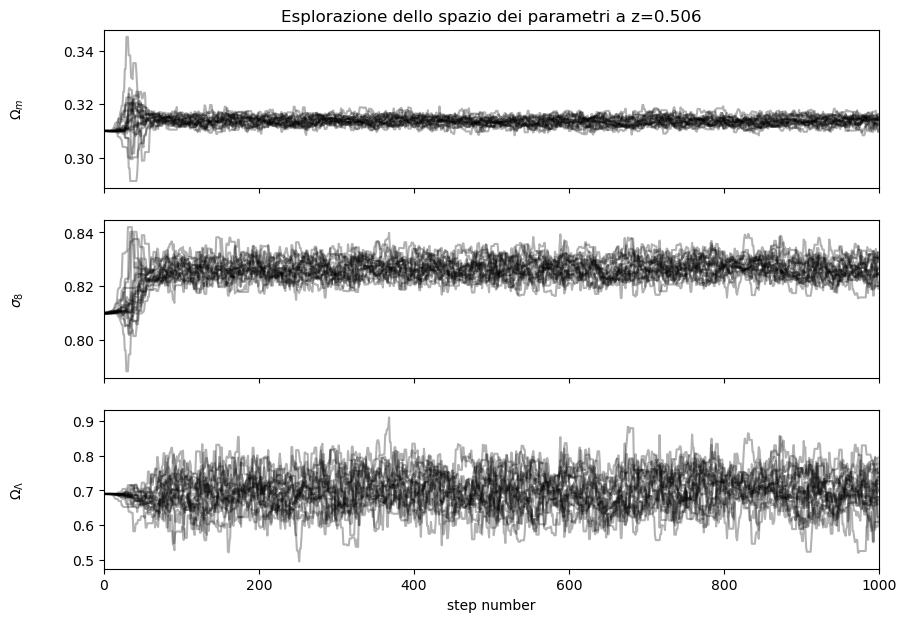

100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


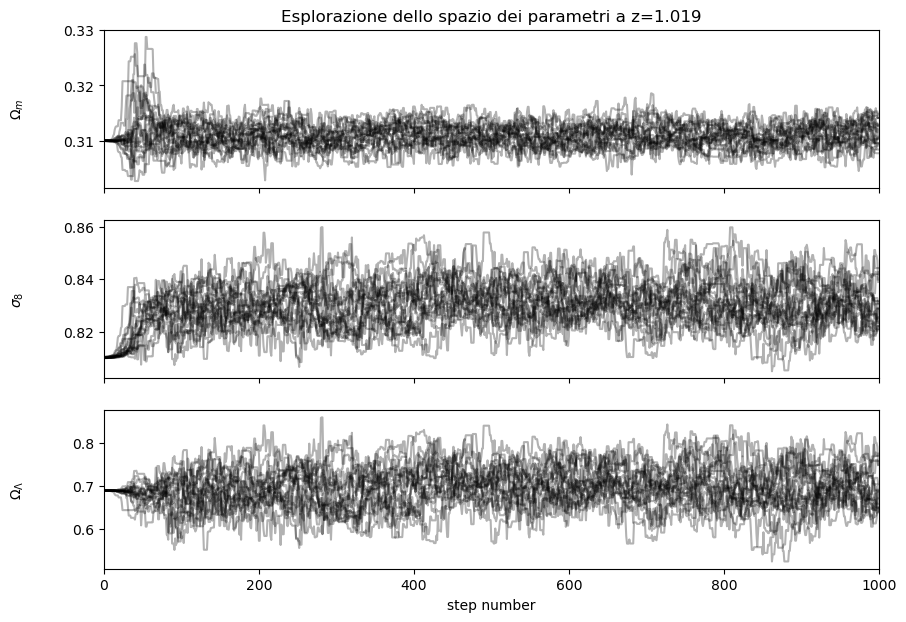

100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]


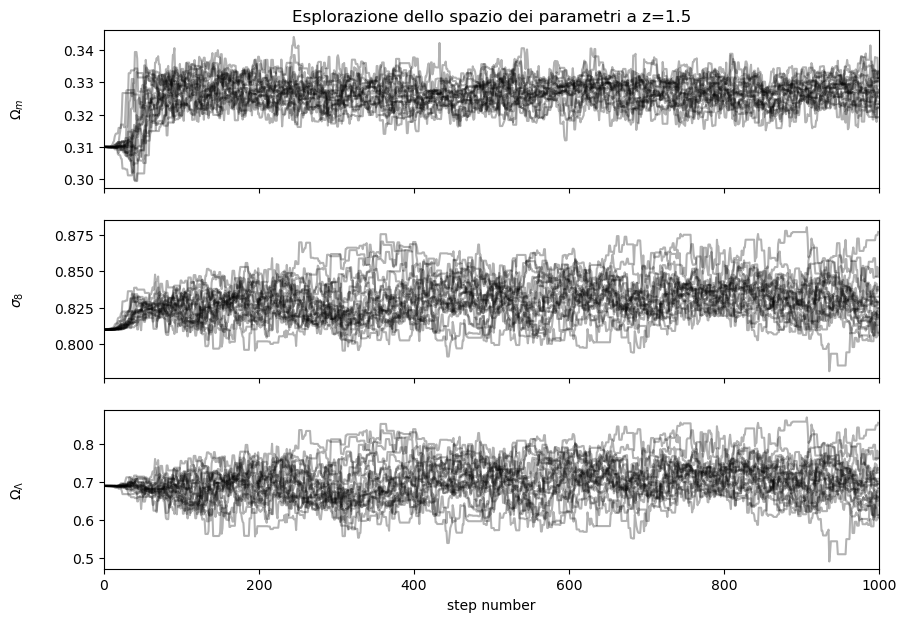

In [271]:
campione_curv=[]
for i,z in enumerate(z_val):

    #avvio dell'algoritmo EMCEE: 20 walkers e 1000 steps
    np.random.seed(42)
    pos = np.array([0.31, 0.81, 0.69]) *(1+ 1e-4 * np.random.randn(20, 3))
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_curv, args=(z,es_bin[i],dm[i],vol_val[i],conteggi[i]))
    sampler.run_mcmc(pos, 1000, progress=True)

    #rappresento graficamente l'esplorazione dello spazio dei parametri
    fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["$\\Omega_m$", "$\\sigma_8$", "$\\Omega_\\Lambda$"]
    for j in range(ndim):
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    axes[0].set_title(f"Esplorazione dello spazio dei parametri a z={z}")
    plt.show()

    #estraggo il campione
    flat_samples = sampler.get_chain(discard=200, flat=True)
    campione_curv.append(flat_samples)

### Osservazioni
Dall’analisi dei grafici rappresentanti l'esplorazione dello spazio dei parametri, si osserva che, in seguito ad un periodo di _burn-in_ di circa 200 steps, le catene MCMC si sviluppano attorno a valori ben definiti senza mostrare segni di divergenza. Ciascuna catena tende infatti a stabilizzarsi attorno al valore d'aspettazione della distribuzione, che corrisponde al parametro più probabile secondo la distribuzione del posterior.

In accordo con la legge dei grandi numeri, la media dei campioni estratti tende al valore d'aspettazione della distribuzione al crescere del numero di iterazioni. Supponendo quindi che le catene abbiano raggiunto una lunghezza sufficiente e che i singoli valori dei parametri siano tra loro indipendenti, le migliori stime dei parametri cosmologici $\Omega_m$, $\sigma_8$ e $\Omega_\Lambda$ possono essere ottenute come media complessiva dei valori campionati. Ciascuna stima può essere accompagnata dalla rispettiva deviazione standard, la quale quantifica l’incertezza statistica sul valore del parametro.

In [275]:
camp_curv=np.array(campione_curv)
stime=pd.DataFrame()
for i,z in enumerate(z_val):
    dict={'$\\Omega_m$':camp_curv[i,:,0], '$\\sigma_8$':camp_curv[i,:,1], '$\\Omega_\\Lambda$':camp_curv[i,:,2]} #seleziono le singole colonne per ogni z
    df=pd.DataFrame(dict,index=np.arange(i*len(camp_curv[i,:,0]),(i+1)*len(camp_curv[i,:,0]),1))
    df['z']=z
    stime=pd.concat([stime,df],axis=0)
stime.groupby('z').aggregate(['mean','std'])

$\Omega_m$           $\sigma_8$           $\Omega_\Lambda$          
            mean       std       mean       std             mean       std
z                                                                         
0.506   0.313677  0.001604   0.826585  0.003604         0.699438  0.050845
1.019   0.310860  0.002060   0.831212  0.008190         0.699078  0.047806
1.500   0.326793  0.003977   0.831709  0.014301         0.705410  0.053794

Si verifica la **compatibilità** delle stime ottenute con i valori dei **parametri iniziali** entro tre deviazioni standard.

In [278]:
cond=(np.mean(camp_curv,axis=1)-3*np.std(camp_curv,axis=1))<=np.array([[0.31,0.81,0.69],[0.31,0.81,0.69],[0.31,0.81,0.69]])
comp=np.where(cond,'Si', 'No')
df=pd.DataFrame({'$\\Omega_m$':comp[:,0], '$\\sigma_8$':comp[:,1], '$\\Omega_\\Lambda$':comp[:,2]},index=z_val)
df

,$\Omega_m$,$\sigma_8$,$\Omega_\Lambda$
0.506,Si,No,Si
1.019,Si,Si,Si
1.500,No,Si,Si


Solo due valori dei parametri stimati non sono compatibili con i valori iniziali ($\Omega_m=0.31$, $\sigma_8=0.81$, $\Omega_\Lambda=0.69$).

Si verifica la **reciproca compatibilità** delle stime ottenute entro tre deviazioni standard.

In [281]:
comp=[]
for i,z in enumerate(z_val):
    cond= np.abs(np.mean(camp_curv,axis=1)[i-1,:]-np.mean(camp_curv,axis=1)[i,:]) <= 3*np.sqrt(np.var(camp_curv,axis=1)[i-1,:]+np.var(camp_curv,axis=1)[i,:])
    comp.append(np.where(cond,'Si', 'No'))
comp=np.array(comp)
df=pd.DataFrame({'$\\Omega_m$':comp[:,0], '$\\sigma_8$':comp[:,1], '$\\Omega_\\Lambda$':comp[:,2]},index=['0.506 vs 1.500', '0.506 vs 1.019', '1.019 vs 1.500'])
df

,$\Omega_m$,$\sigma_8$,$\Omega_\Lambda$
0.506 vs 1.500,No,Si,Si
0.506 vs 1.019,Si,Si,Si
1.019 vs 1.500,No,Si,Si


Solo due coppie di parametri stimati non sono compatibili tra loro.

Di seguito si rappresenta graficamente la distribuzione dei tre parametri stimati per ciascun valore di redshift. In particolare si rappresenta la distribuzione del posterior ricavata dall'algoritmo EMCEE e proiettata sullo spazio dei parametri. Per ogni parametro si ottengono anche le distribuzioni marginali.

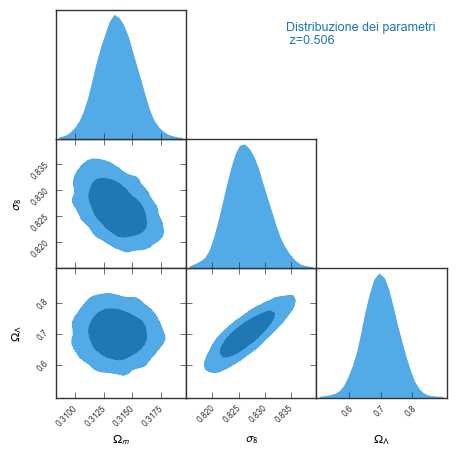

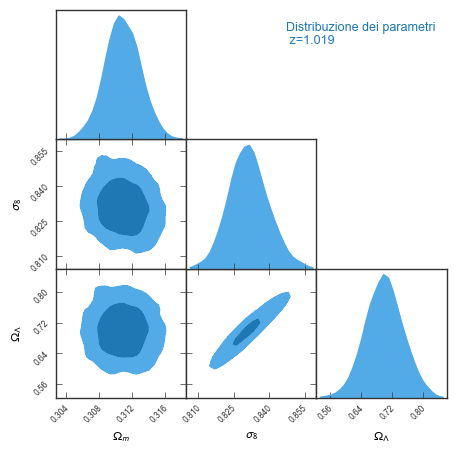

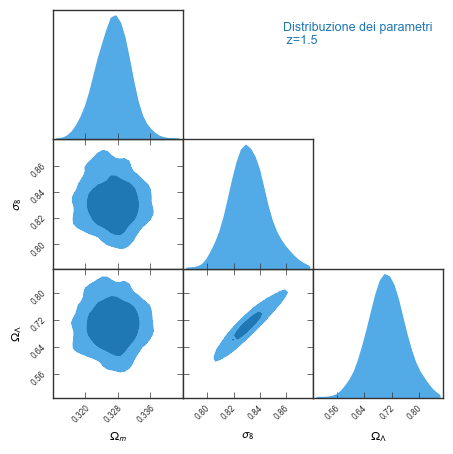

In [284]:
for i,z in enumerate(z_val):
    GTC = pygtc.plotGTC(chains=campione_curv[i],
                        paramNames=["$\\Omega_m$", "$\\sigma_8$", "$\\Omega_\\Lambda$"],
                        chainLabels=[f'Distribuzione dei parametri\n z={z}'],
                        figureSize='MNRAS_page')

Si intende calcolare i coefficienti di correlazione tra $\Omega_m$, $\Omega_\Lambda$ e $\sigma_8$ per ogni valore di redshift.

In [287]:
corr_coef=[[],[],[]]
for i,z in enumerate(z_val):
    corr_matrix=np.corrcoef(camp_curv[i,:,:].T) #estraggo la matrice dei coefficienti di correlazione dal campione
    corr_coef[i].append([corr_matrix[0,1],corr_matrix[0,2],corr_matrix[1,2]])
corr_coef=np.array(corr_coef).reshape(3,3)
df=pd.DataFrame({'$\\rho(\\Omega_m,\\sigma_8)$':corr_coef[:,0],'$\\rho(\\Omega_m,\\Omega_\\Lambda)$':corr_coef[:,1],'$\\rho(\\Omega_\\Lambda,\\sigma_8)$':corr_coef[:,2]},index=z_val)
df

,"$\rho(\Omega_m,\sigma_8)$","$\rho(\Omega_m,\Omega_\Lambda)$","$\rho(\Omega_\Lambda,\sigma_8)$"
0.506,-0.449775,-0.038488,0.900798
1.019,-0.135474,-0.019468,0.991511
1.500,-0.063774,-0.011595,0.996492


### Osservazioni
Dai grafici sopra riportati si osserva che le distribuzioni marginali risultano pressoché simmetriche intorno al proprio valore d'aspettazione, confermando la casualità del campionamento dell'algoritmo EMCEE. Inoltre la proiezione della distribuzione multivariata sullo spazio dei parametri $\Omega_\Lambda-\sigma_8$ assume la forma di un’ellisse inclinata con pendenza positiva, evidenziando una correlazione diretta tra i parametri. La proiezione della distribuzione sullo spazio $\sigma_8-\Omega_m$ assume una lieve forma di ellisse con inclinazione negativa, sempre più marcata al diminuire del redshift, suggerendo una debole correlazione tra i parametri; nell'analisi precedente la correlazione negativa era molto più evidente. Infine, sullo spazio $\Omega_\Lambda-\Omega_m$, è possibile osservare una proiezione di forma pressochè circolare: le varianze dei due parametri sono molto simili tra loro e risulta esserci una correlazione tra questi quasi assente. I valori dei coefficienti di correlazione sono riportati sopra.

A partire da questi valori ottimizzati, è possibile calcolare una nuova previsione teorica dei conteggi mediante la _Halo Mass Function_ (HMF) e confrontarla nuovamente con i dati osservati. 
Si potrà verificare nuovamente se l’impiego dei nuovi parametri stimati consenta di ottenere un ancora migliore accordo tra modello teorico e osservazioni. Si mostra tale confronto.

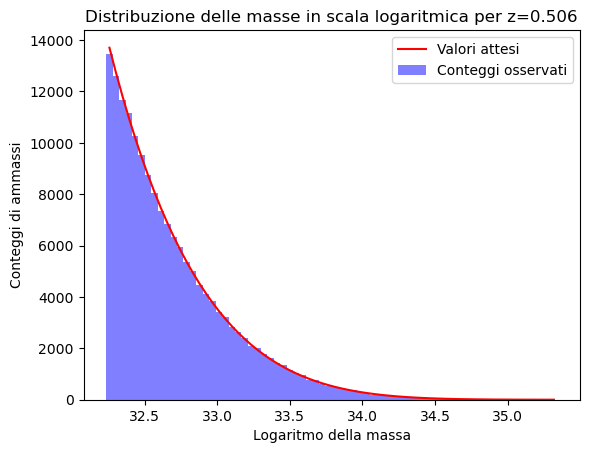

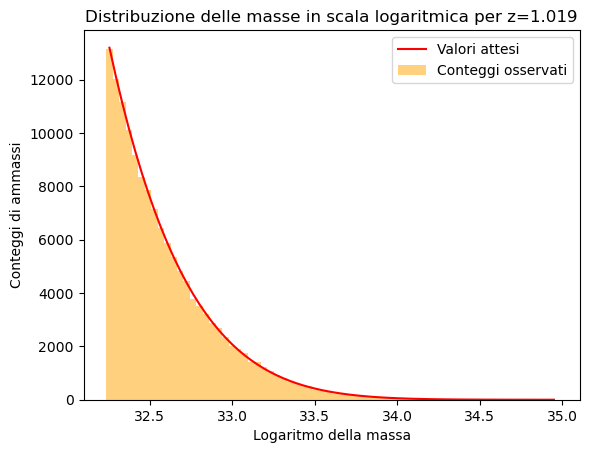

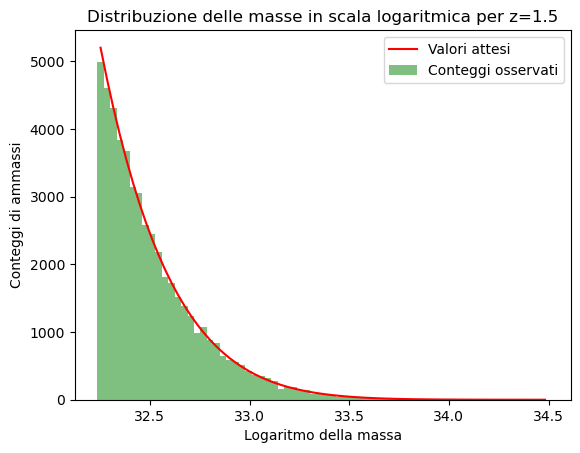

In [290]:
colori=['blue','orange','green']
chi_sq_curv=[0,0,0]
gdl_curv=[-4,-4,-4]
for i,z in enumerate(z_val):
    
    #calcolo i valori attesi con i parametri ottimizzati
    m_arr,val_att=mfunc_curv(np.mean(camp_curv,axis=1)[i,:],z,es_bin[i],dm[i],vol_val[i])
    plt.plot(np.log(m_arr), val_att, c='red', label='Valori attesi')
    
    #ricreo gli istogrammi
    plt.hist(np.log(masse[i]),bins=70,color=colori[i],alpha=0.5,label='Conteggi osservati')
    
    plt.xlabel('Logaritmo della massa')   
    plt.ylabel('Conteggi di ammassi')   
    plt.title(f'Distribuzione delle masse in scala logaritmica per z={z}')
    plt.legend()
    plt.show()

    #calcolo chi^2 del test di Pearson (discusso alla fine della relazione)
    for j in range(len(conteggi[i])):
        if conteggi[i][j]>=5:
            chi_sq_curv[i]+=(conteggi[i][j]-val_att[j])**2/val_att[j]
            gdl_curv[i]+=1
chi_red_curv=np.array(chi_sq_curv)/np.array(gdl_curv)

Viene ripresentato il grafico dei residui con i nuovi valori attesi.

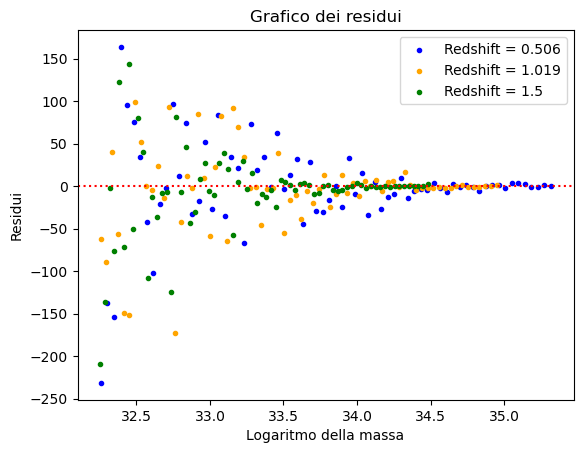

In [293]:
colori=['blue','orange','green']
for i,z in enumerate(z_val):
    
    #ricalcolo i valori attesi
    m_arr,val_att=mfunc_curv(np.mean(camp_curv,axis=1)[i,:],z,es_bin[i],dm[i],vol_val[i])
    
    res=conteggi[i]-val_att #calcolo dei residui
    plt.scatter(np.log(m_arr),res,color=colori[i],marker='.',label='Redshift = {}'.format(z))

plt.axhline(y=0, xmin=0, xmax=35.5,c='red',ls=':')
plt.xlabel('Logaritmo della massa')   
plt.ylabel('Residui')   
plt.title('Grafico dei residui')
plt.legend()
plt.show()

### Osservazioni
Dall’osservazione del confronto degli istogrammi con i nuovi valori attesi calcolati, emerge un accordo tra modello teorico e dati empirici paragonabile, e senza palesi miglioramenti, all'analisi precedente: i valori d'aspettazione di $\Omega_m$, $\sigma_8$ e $\Omega_\Lambda$, ricavati dall'algoritmo EMCEE, si dimostrano dunque ugualmente accurati al fine di rappresentare la distribuzione degli ammassi di galassie osservati. Il nuovo grafico dei residui è qualitativamente paragonabile all'ultima analisi condotta.

Come preannunciato in precedenza, l’analisi di un universo non necessariamente piatto introduce tra i parametri anche $\Omega_k$, che rappresenta la densità di curvatura dell’universo:

$$
\Omega_k = 1 - \Omega_m - \Omega_\Lambda
$$

Dall’analisi delle distribuzioni congiunte si osserva che $\Omega_m$ e $\Omega_\Lambda$ non mostrano una correlazione significativa; è quindi ragionevole trattarle come variabili indipendenti. In questo caso, la distribuzione di $\Omega_k$ può essere ottenuta a partire dalla convoluzione delle distribuzioni marginali di $\Omega_m$ e $\Omega_\Lambda$. Poiché entrambe risultano approssimabili con gaussiane indipendenti, anche $\Omega_k$ seguirà una distribuzione gaussiana, caratterizzata da:

$$
\mu_k = 1 - \mu_m - \mu_\Lambda \qquad 
\sigma^2_k = \sigma^2_m + \sigma^2_\Lambda
$$

A partire dalle catene MCMC, per ogni campione $(\Omega_m, \Omega_\Lambda)$ si può calcolare il corrispondente valore di $\Omega_k$, ottenendo così una distribuzione campionata di questo parametro. Tale distribuzione, rappresentata graficamente, permette di stimare il valore d'aspettazione e la varianza di $\Omega_k$ per ciascun intervallo di redshift considerato, fornendo un’indicazione diretta sull’eventuale curvatura dell’universo e sulla sua evoluzione con il redshift.

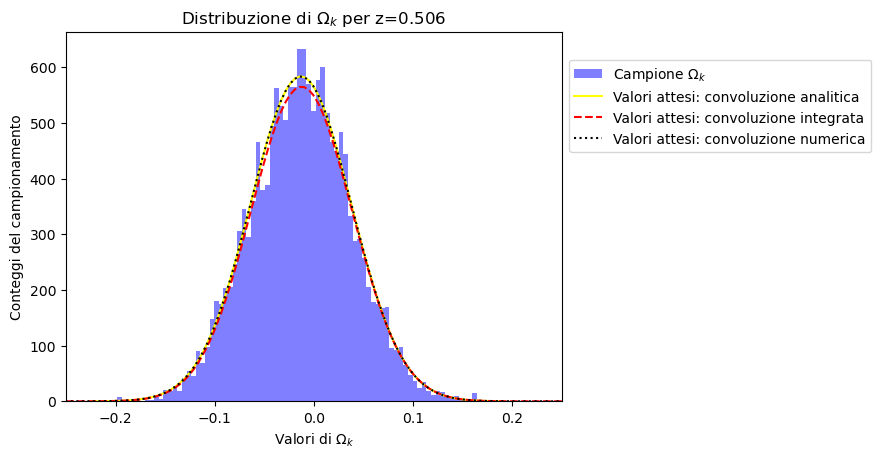

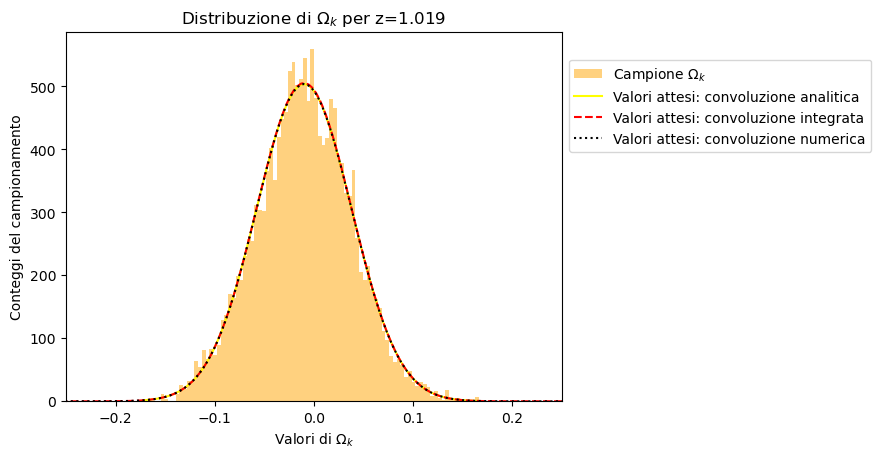

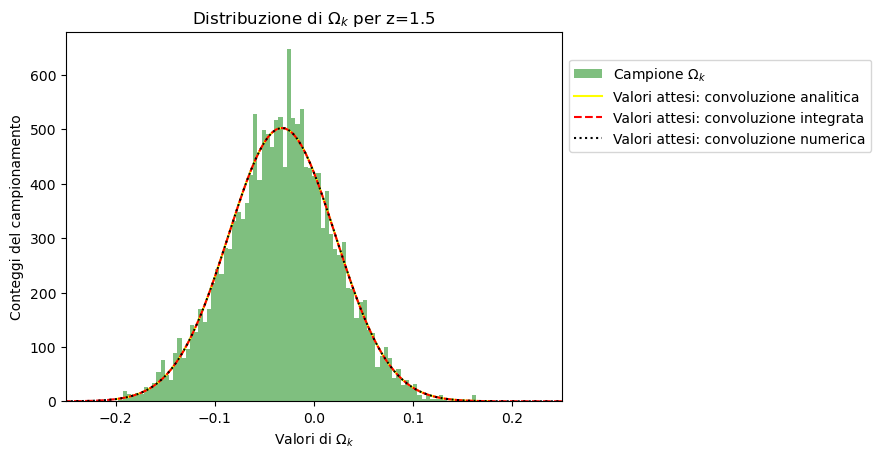

In [299]:
colori=['blue','orange','green']
Omk=[[],[],[]]
conv=[[],[],[]]
histo=[[],[],[]]
for i,z in enumerate(z_val):

    #estraggo i campioni di Omk, mu_k, sigma_k con le formule sopra
    Omk[i]=1-camp_curv[i,:,0]-camp_curv[i,:,2]
    mu_k=1-np.mean(camp_curv,axis=1)[:,0]-np.mean(camp_curv,axis=1)[:,2]
    sigma_k=np.sqrt(np.var(camp_curv,axis=1)[:,0]+np.var(camp_curv,axis=1)[:,2])

    #istogramma campione Omk
    plt.hist(Omk[i],bins=90,color=colori[i],alpha=0.5,label='Campione $\\Omega_k$')
    
    #ricavo i centri dei bin dell'istogramma e il loro spessore
    histo[i], bin_edges=np.histogram(Omk[i], bins=90)
    bin_cent=(bin_edges[:-1] + bin_edges[1:])/2
    d_bin=bin_cent[1]-bin_cent[0]
    xarr = np.arange(1-np.min(bin_cent)+d_bin*25, -0.3, -d_bin)[::-1] #centri dei bin estesi per calcolare le convoluzioni

    #calcolo i valori attesi con la convoluzione analitica
    conv[i]=stats.norm.pdf(bin_cent, loc=mu_k[i], scale=sigma_k[i])*np.sum(histo[i])*d_bin
    plt.plot(bin_cent, conv[i], color='yellow', label='Valori attesi: convoluzione analitica')

    #calcolo i valori attesi con la convoluzione integrata
    convoluzione_valori = np.zeros_like(xarr)
    f1=stats.norm.pdf(xarr, loc=np.mean(camp_curv,axis=1)[i,0], scale=np.std(camp_curv,axis=1)[i,0])
    for j, t in enumerate(xarr):
        f2=stats.norm.pdf(t-xarr, loc=np.mean(camp_curv,axis=1)[i,2], scale=np.std(camp_curv,axis=1)[i,2])
        prodotto = f1*f2
        convoluzione_valori[j] = np.trapz(prodotto, dx=d_bin)*np.sum(histo[i])*d_bin
    plt.plot(1-xarr, convoluzione_valori, '--r', label='Valori attesi: convoluzione integrata') #riscalo le ascisse per centrare la convoluzione su mu_k

    #calcolo i valori attesi con la convoluzione numerica
    f3=stats.norm.pdf(xarr, loc=np.mean(camp_curv,axis=1)[i,2], scale=np.std(camp_curv,axis=1)[i,2])
    convoluzione = np.convolve(f1, f3, mode='same')
    convoluzione = convoluzione*np.sum(histo[i])*d_bin/np.trapz(convoluzione, xarr)
    xmedio = np.trapz(convoluzione*xarr,xarr)/np.trapz(convoluzione, xarr) #valor medio della convoluzione
    newx = xarr-xmedio+mu_k[i] #riscalo le ascisse per centrare la convoluzione su mu_k
    plt.plot(newx, convoluzione, ':k', label='Valori attesi: convoluzione numerica')
    
    plt.xlabel('Valori di $\\Omega_k$')   
    plt.ylabel('Conteggi del campionamento')   
    plt.title(f'Distribuzione di $\\Omega_k$ per z={z}')
    plt.xlim(-0.25,0.25)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.8))
    plt.show()

Omk=np.array(Omk)
conv=np.array(conv)
histo=np.array(histo)

Si mostrano ora le tre distribuzioni di $\Omega_k$ poste a confronto.

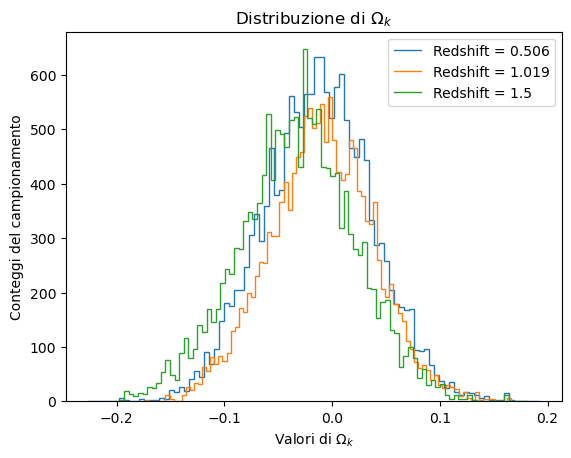

In [302]:
for i,z in enumerate(z_val):  
    frequenze, bins=np.histogram(Omk[i], bins=90)
    plt.stairs(frequenze, bins, label='Redshift = {}'.format(z))
    
plt.xlabel('Valori di $\\Omega_k$')
plt.ylabel('Conteggi del campionamento')
plt.title('Distribuzione di $\\Omega_k$')
plt.legend()
plt.show()

Di seguito vengono presentati i valori numerici relativi a $\Omega_k$.

In [305]:
stime=pd.DataFrame()
for i,z in enumerate(z_val):
    dict={'$\\Omega_k$':Omk[i]}
    df=pd.DataFrame(dict,index=np.arange(i*len(Omk[i]),(i+1)*len(Omk[i]),1))
    df['z']=z
    df['$\\mu_k$']=mu_k[i]
    df['$\\sigma_k$']=sigma_k[i]
    stime=pd.concat([stime,df],axis=0)
stime.groupby(['z','$\\mu_k$','$\\sigma_k$']).aggregate(['mean','std'])

$\Omega_k$          
                                 mean       std
z     $\mu_k$   $\sigma_k$                     
0.506 -0.013115 0.050869    -0.013115  0.050809
1.019 -0.009938 0.047849    -0.009938  0.047810
1.500 -0.032203 0.053939    -0.032203  0.053895

Si verifica la **reciproca compatibilità** delle stime ottenute entro tre deviazioni standard.

In [308]:
comp=[]
for i,z in enumerate(z_val):
    cond= np.abs(np.mean(Omk,axis=1)[i-1]-np.mean(Omk,axis=1)[i]) <= 3*np.sqrt(np.var(Omk,axis=1)[i-1]+np.var(Omk,axis=1)[i])
    comp.append(np.where(cond,'Si', 'No'))
comp=np.array(comp)
df=pd.DataFrame({'$\\Omega_k$':comp},index=['0.506 vs 1.500', '0.506 vs 1.019', '1.019 vs 1.500'])
df

,$\Omega_k$
0.506 vs 1.500,Si
0.506 vs 1.019,Si
1.019 vs 1.500,Si


Si verifica la **compatibilità** delle stime ottenute con **zero** entro **una** deviazione standard.

In [311]:
cond=(np.mean(Omk,axis=1)+np.std(Omk,axis=1))>=np.array([0.0,0.0,0.0])
comp=np.where(cond,'Si', 'No')
df=pd.DataFrame({'$\\Omega_K$':comp},index=z_val)
df

,$\Omega_K$
0.506,Si
1.019,Si
1.500,Si


Confermata la compatibilità reciproca dei valori d'aspettazione, e la visiva sovrapponibilità approssimativa dei tre istogrammi, si intende ora unire i tre campioni di $\Omega_k$ per condurne un'analisi congiunta.

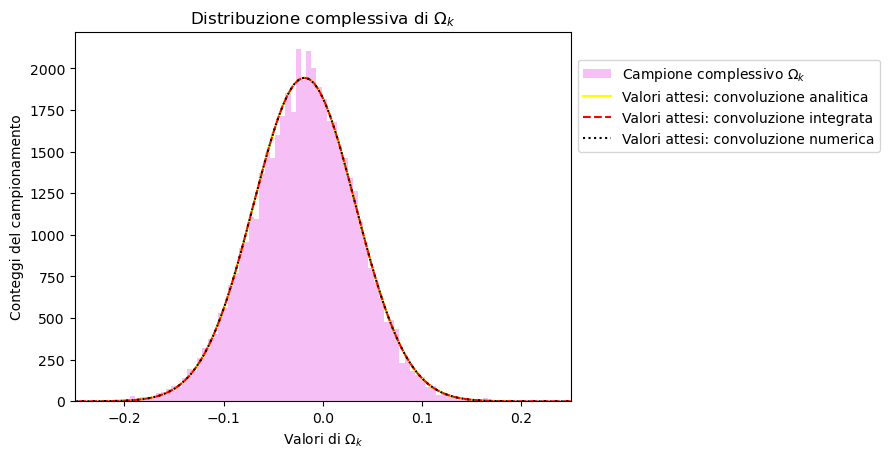

In [316]:
#estraggo i campioni di Omk, mu_k, sigma_k con le formule sopra e altri parametri utili
Omk_tot=1-camp_curv[:,:,0].reshape(3*len(camp_curv[0,:,0]))-camp_curv[:,:,2].reshape(3*len(camp_curv[0,:,2]))
mu_m_tot=camp_curv[:,:,0].reshape(3*len(camp_curv[0,:,0])).mean()
mu_lambda_tot=camp_curv[:,:,2].reshape(3*len(camp_curv[0,:,2])).mean()
mu_k_tot=1-mu_m_tot-mu_lambda_tot
sigma_m_tot=camp_curv[:,:,0].reshape(3*len(camp_curv[0,:,0])).std()
sigma_lambda_tot=camp_curv[:,:,2].reshape(3*len(camp_curv[0,:,2])).std()
sigma_k_tot=np.sqrt(sigma_m_tot**2+sigma_lambda_tot**2)

#istogramma campione Omk
plt.hist(Omk_tot,bins=80,color='violet',alpha=0.5,label='Campione complessivo $\\Omega_k$')
    
#ricavo i centri dei bin dell'istogramma e il loro spessore
histo_tot, bin_edges=np.histogram(Omk_tot, bins=80)
bin_cent=(bin_edges[:-1] + bin_edges[1:])/2
d_bin=bin_cent[1]-bin_cent[0]
xarr = np.arange(1-np.min(bin_cent)+d_bin*25, -0.3, -d_bin)[::-1] #centri dei bin estesi per calcolare le convoluzioni

#calcolo i valori attesi con la convoluzione analitica
conv_tot=stats.norm.pdf(bin_cent, loc=mu_k_tot, scale=sigma_k_tot)*np.sum(histo_tot)*d_bin
plt.plot(bin_cent, conv_tot, color='yellow', label='Valori attesi: convoluzione analitica')

#calcolo i valori attesi con la convoluzione integrata
convoluzione_valori = np.zeros_like(xarr)
f1=stats.norm.pdf(xarr, loc=mu_m_tot, scale=sigma_m_tot)
for j, t in enumerate(xarr):
    f2=stats.norm.pdf(t-xarr, loc=mu_lambda_tot, scale=sigma_lambda_tot)
    prodotto = f1*f2
    convoluzione_valori[j] = np.trapz(prodotto, dx=d_bin)*np.sum(histo_tot)*d_bin
plt.plot(1-xarr, convoluzione_valori, '--r', label='Valori attesi: convoluzione integrata') #riscalo le ascisse per centrare la convoluzione su mu_k

#calcolo i valori attesi con la convoluzione numerica
f3=stats.norm.pdf(xarr, loc=mu_lambda_tot, scale=sigma_lambda_tot)
convoluzione = np.convolve(f1, f3, mode='same')
convoluzione = convoluzione*np.sum(histo_tot)*d_bin/np.trapz(convoluzione, xarr)
xmedio = np.trapz(convoluzione*xarr,xarr)/np.trapz(convoluzione, xarr) #valor medio della convoluzione
newx = xarr-xmedio+mu_k_tot #riscalo le ascisse per centrare la convoluzione su mu_k
plt.plot(newx, convoluzione, ':k', label='Valori attesi: convoluzione numerica')
    
plt.xlabel('Valori di $\\Omega_k$')   
plt.ylabel('Conteggi del campionamento')   
plt.title('Distribuzione complessiva di $\\Omega_k$')
plt.xlim(-0.25,0.25)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.8))
plt.show()

Omk_tot=np.array(Omk_tot)
conv_tot=np.array(conv_tot)
histo_tot=np.array(histo_tot)

Di seguito vengono presentati i valori numerici relativi a $\Omega_k$ nel campionamento complessivo.

In [319]:
df=pd.DataFrame({'$\\Omega_k^{tot}$':Omk_tot,'$\\mu_k$':mu_k_tot,'$\\sigma_k$':sigma_k_tot})
df.groupby(['$\\mu_k$','$\\sigma_k$']).aggregate(['mean','std'])

$\Omega_k^{tot}$          
                                 mean       std
$\mu_k$   $\sigma_k$                           
-0.018419 0.051499          -0.018419  0.051839

Si verifica la **compatibilità** della stima ottenuta con **zero** entro **una** deviazione standard.

In [322]:
cond=(Omk.mean()+Omk.std())>=0.0
comp=np.where(cond,'Si', 'No')
print(f'Il valore di aspettazione complessivo è compatibile con zero? {comp}')

Il valore di aspettazione complessivo è compatibile con zero? Si


### Osservazioni
L’analisi dei campioni di $\Omega_k$ mostra che le relative distribuzioni suddivise per redshift sono approssimativamente centrate attorno a zero (compatibilità con zero già entro una deviazione standard $\sigma_k$) e sono pressoché simmetriche rispetto al valore centrale. I risultati confermano inoltre la coerenza dell’ipotesi formulata, secondo cui $\Omega_k$ segue una distribuzione gaussiana con valore d'aspettazione e varianza:

$$
\mu_k = 1 - \mu_m - \mu_\Lambda \qquad 
\sigma^2_k = \sigma^2_m + \sigma^2_\Lambda
$$  

Questo è in accordo con la teoria della propagazione degli errori, secondo cui la combinazione di variabili gaussiane indipendenti produce a sua volta una distribuzione gaussiana. Le tre modalità di convoluzione che sono state eseguite rappresentano piuttosto bene la predizione dei valori attesi. Anche la distribuzione del campione complessivo di $\Omega_k$ mostra una compatibilità con zero entro una devizione standard ed un accordo con i valori attesi delle convoluzioni calcolate.

Si verifica ora la bontà dei valori attesi su tutti i campioni di $\Omega_k$ tramite il test di Pearson. Il calcolo dei $\chi^2$, dei gradi di libertà ($gdl$) e dei $\chi^2_{red}$ si ottiene come segue:

$$
\chi^2=\sum^N_{i=1}\frac{(\Omega_{k,i}-\eta_{k,i})^2}{\eta_{k,i}} \qquad
gdl=N-1-n \qquad
\chi^2_{red}=\chi^2/gdl
$$

dove $\Omega_{k,i}$ sono i conteggi sul campione, $\eta_{k,i}$ sono i valori attesi calcolati con la convoluzione analitica e $n$ sono il numero di parametri stimati con il campione per calcolare i valori attesi (in questo caso 2: $\mu_k$ e $\sigma_k$).

In [325]:
chi_sq=[0,0,0,0]
gdl=[-3,-3,-3,-3]
for i,z in enumerate(z_val):
    for j in range(len(histo[i,:])):
        if histo[i,j]>=5:
            chi_sq[i]+=(histo[i,j]-conv[i,j])**2/conv[i,j]
            gdl[i]+=1
for j in range(len(histo_tot)):
    if histo_tot[j]>=5:
        chi_sq[3]+=(histo_tot[j]-conv_tot[j])**2/conv_tot[j]
        gdl[3]+=1
chi_red=np.array(chi_sq)/np.array(gdl)
df=pd.DataFrame({'$\\chi^2$':chi_sq,'gdl':gdl,'$\\chi^2_{red}$':chi_red,'$\\chi^2_{0.05}$':[85.96,92.81,93.95,85.96]}, index=['$\\Omega_k^{0.506}$','$\\Omega_k^{1.019}$','$\\Omega_k^{1.500}$','$\\Omega_k^{tot}$'])
df

,$\chi^2$,gdl,$\chi^2_{red}$,$\chi^2_{0.05}$
$\Omega_k^{0.506}$,341.336290,66,5.171762,85.96
$\Omega_k^{1.019}$,284.704297,72,3.954226,92.81
$\Omega_k^{1.500}$,451.987252,73,6.191606,93.95
$\Omega_k^{tot}$,397.698466,66,6.025734,85.96


Il valore di $\chi^2_{0.05}$ è un numero che stabilisce il limite superiore del $\chi^2$ affinchè l'ipotesi non venga rigettata. Esso dipende dai gradi di libertà e dalla probabilità di rigetto. Per il calcolo di $\chi^2_{0.05}$ è stato utilizzato il seguente link considerando una probabilità di rigetto del 5%: https://www.edutecnica.it/calcolo/conti/conti.htm

I test di Pearson effettuati sui vari campioni portano complessivamente a rigettare l’ipotesi di accordo, suggerendo la necessità di effettuare l’inferenza considerando un numero più elevato di parametri da campionare.

Si espongono ora i test di Pearson relativi alle varie distribuzioni delle masse degli ammassi di galassie, suddivise per redshift, nelle tre diverse analisi: universo piatto con $\Omega_m=0.31$ e $\sigma_8=0.81$; universo piatto con $\Omega_m$ e $\sigma_8$ stimati; universo curvo con $\Omega_m$, $\Omega_\Lambda$ e $\sigma_8$ stimati.

**Universo piatto con $\Omega_m=0.31$ e $\sigma_8=0.81$**

In [330]:
df=pd.DataFrame({'$\\chi^2$':chi_sq_flat,'gdl':gdl_flat,'$\\chi^2_{red}$':chi_red_flat,'$\\chi^2_{0.05}$':[83.68,72.15,62.83]}, index=z_val)
df

,$\chi^2$,gdl,$\chi^2_{red}$,$\chi^2_{0.05}$
0.506,1646.250894,64,25.722670,83.68
1.019,4168.529120,54,77.194984,72.15
1.500,3559.104081,49,72.634777,62.83


**Universo piatto con $\Omega_m$ e $\sigma_8$ stimati**

In [333]:
df=pd.DataFrame({'$\\chi^2$':chi_sq_flatp,'gdl':gdl_flatp,'$\\chi^2_{red}$':chi_red_flatp,'$\\chi^2_{0.05}$':[81.38,69.83,64.00]}, index=z_val)
df

,$\chi^2$,gdl,$\chi^2_{red}$,$\chi^2_{0.05}$
0.506,75.561837,62,1.218739,81.38
1.019,108.122528,52,2.079279,69.83
1.500,133.463879,47,2.839657,64.00


**Universo curvo con $\Omega_m$, $\Omega_\Lambda$ e $\sigma_8$ stimati**

In [336]:
df=pd.DataFrame({'$\\chi^2$':chi_sq_curv,'gdl':gdl_curv,'$\\chi^2_{red}$':chi_red_curv,'$\\chi^2_{0.05}$':[80.23,68.67,62.83]}, index=z_val)
df

,$\chi^2$,gdl,$\chi^2_{red}$,$\chi^2_{0.05}$
0.506,75.525883,61,1.238129,80.23
1.019,108.295763,51,2.123446,68.67
1.500,134.528425,46,2.924531,62.83


Dai risultati dei test di Pearson sulle distribuzioni di massa emerge che la maggioranza rigetta l'ipotesi di accordo con una probabilità di rigetto pari al 5%. Tuttavia è inoltre evidente dai valori dei $\chi^2$ il migliore accordo delle previsioni degli ultimi due modelli, i quali condividono il fatto di aver stimato i parametri, rispetto a quello con i valori fissati per $\Omega_m$ e $\sigma_8$. I $\chi^2$ sono più bassi per valori di redshift minori, probabilmente dovuto al maggiore numero di campioni nella suddivisione.
### Conclusioni
In questa relazione è stata presentata un’analisi basata su un catalogo di ammassi di galassie, scelto con caratteristiche analoghe a quelle che saranno osservate dalla missione Euclid. L’obiettivo principale è stato lo studio della distribuzione delle masse di tali strutture e la verifica della loro coerenza con le previsioni dei modelli teorici. A partire da questo confronto, sono stati stimati i parametri cosmologici fondamentali e analizzate le loro distribuzioni a posteriori mediante inferenza statistica. L’indagine è stata condotta in scenari diversi, considerando sia un universo piatto sia un universo curvo.

L’analisi condotta sui dati degli ammassi di galassie e la successiva stima dei parametri cosmologici hanno fornito risultati coerenti e significativi, confermando la solidità delle ipotesi teoriche sulla struttura dell’Universo. Il modello utilizzato si è dimostrato adeguato a descrivere le osservazioni, sia nel caso di universo piatto sia in quello di universo curvo, consentendo attraverso l’inferenza bayesiana di ottenere stime precise dei parametri fondamentali per lo studio dell’universo e dell’energia oscura. In particolare, l’impiego dell'algoritmo EMCEE si è rivelato uno strumento efficace per l’estrapolazione dei campioni sui parametri, permettendo di descrivere con buona approssimazione l’andamento delle distribuzioni e garantendo stime compatibili con le osservazioni. Nel complesso, nonostante il rigetto dei test di Pearson, i risultati conseguiti supportano l’affidabilità del modello teorico considerato e contribuiscono ad una migliore comprensione dell’universo osservato ai fini della missione Euclid.